# BERT TRAINING

Note: This notebook was meant to be run in [Google Colab](https://colab.research.google.com/) due to the hardware requirements needed to train BERT. It is placed here for reference purposes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import os
from torch import nn, optim, device, cuda, Tensor, LongTensor, argmax, bincount
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from transformers import BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
import random

## Constants

In [ ]:
# Locate the train and test datasets
DATASET_TRAIN = '/content/drive/MyDrive/School/Thesis - Hate Speech/Data/dataset-train.csv'
DATASET_TEST = '/content/drive/MyDrive/School/Thesis - Hate Speech/Data/dataset-test.csv'

# Set to True to save the model in the directory listed
# in MODEL_FOLDER
SAVE_MODEL = True
MODEL_FOLDER = '/content/drive/MyDrive/models/sample'

# Use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [ ]:
# How many lines the model processes at the same time
BATCH_SIZE = 32

# Longest amount of tokens that the model can analyze
# at one time
MAX_LENGTH = 250

# Scales how much parameters are updated
# in each step during training
LEARNING_RATE = 2.20E-05

# Determines when we stop training
# How many times to perform a complete pass through
# the dataset during training
MAX_EPOCHS = 2

**Batch Size** - how many lines the model processes at the same time. A larger batch size allows the model to analyze more lines together, which can make the overall process faster, but may require more computer memory.

**Maximum Length** -  the longest amount of tokens that the model can analyze at one time.

## Utility Functions

### Model saving & folder creation

In [ ]:
if SAVE_MODEL:
  os.makedirs(
    MODEL_FOLDER,
    exist_ok=True, # Create folder if it doesn't exist, else do nothing
  )

  print(f"Saving model at '{MODEL_FOLDER}'")

Saving model at '/content/drive/MyDrive/models/model_bert_52'


### Read CSV file

In [ ]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

dataset_train = read_csv_file(DATASET_TRAIN)
dataset_test = read_csv_file(DATASET_TEST)

CSV file read successfully!
CSV file read successfully!


In [ ]:
dataset_train

,text,label
0,Matthew Chang [USERNAME] Remind ko lang di ba ...,1
1,Yay! The interview served its purpose wellJess...,0
2,I say DASURV,0
3,TayNew said Let Leni Lead,0
4,Gloc 9 is not endorsing Jejomar Binay as his p...,0
...,...,...
22764,Nov. 11: on [USERNAME] saw tv ads of Jojo Bina...,1
22765,Mar Roxas your call for unity describes one th...,1
22766,Buti nalang nagdecide nakong hindi manood ng T...,0
22767,sang boto para sa pagbabago. Let Leni Lead phi...,0


In [ ]:
dataset_test

,text,label
0,Hindi susuportahan ng theatre and literary est...,0
1,BABAE LABAN SA FAKE AT FRAUDBFFSUMBONGDAYA DES...,1
2,Im proud to be a Filipino and a kakampink like...,0
3,Grabe noThe hypocrisy of the church to preach ...,1
4,BBMSARAUniteam Ph Arena BBMSARA,0
...,...,...
5687,[USERNAME] Rizalito David is a good man you ca...,0
5688,A very famous religious cult in the Philippine...,1
5689,Tama sir VP Leni Di dapat iboto SI BBM Kase No...,0
5690,RT [USERNAME]: Mar Roxas forever arrogantI can...,1


In [ ]:
X_train = dataset_train['text']
y_train = dataset_train['label']

X_test = dataset_test['text']
y_test = dataset_test['label']

## Multilingual BERT for Sequence Classification

In [ ]:
_model_name = "bert-base-multilingual-uncased"

model = BertForSequenceClassification.from_pretrained(
    _model_name,
    num_labels=2,
).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Multilingual BERT** can understand and work with text written in many different languages, including Tagalog and English. This makes it useful for identifying content in text that mixes those two languages together.

**BERT for Sequence Classification** can analyze the meaning and purpose of text. By training BERT to recognize patterns of hateful or offensive language, it can be used to automatically identify and classify hate speech in written text.

## BERT Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(_model_name)

**Bert Tokenizer** breaks down words into smaller pieces that the BERT language model can understand. It takes regular text and turns it into a format that BERT can analyze to determine the meaning and purpose of the text.

In [ ]:
def tokenize_and_prepare(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    tokens_list = []

    for text in tqdm(texts, desc="Tokenizing"):
        # Tokenize the text
        tokens = tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > max_length - 2:
            tokens = tokens[:max_length - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to max_length
        padding = [0] * (max_length - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)
        tokens_list.append(tokens)  # Append the tokens to the list

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks, tokens_list

# Tokenize and prepare the data with progress bars
print("Tokenizing training data...")
train_input_ids, train_attention_masks, train_tokens = tokenize_and_prepare(X_train, tokenizer, MAX_LENGTH)
print("Training data tokenized.")

print("Tokenizing test data...")
test_input_ids, test_attention_masks, test_tokens = tokenize_and_prepare(X_test, tokenizer, MAX_LENGTH)
print("Test data tokenized.")

# Convert labels into tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

Tokenizing training data...


Tokenizing: 100%|██████████| 22769/22769 [00:11<00:00, 2006.76it/s]


Training data tokenized.
Tokenizing test data...


Tokenizing: 100%|██████████| 5692/5692 [00:02<00:00, 2044.00it/s]


Test data tokenized.


The first step in tokenizing is breaking text down into smaller pieces (subwords) and this process is called **WordPiece tokenization**. It then further split out of vocabulary words into sub words.

**Special tokens** are added, `[CLS]` indicating the start of the sentence,`[SEP]` indicating the end of the sentence, and padding so that the number of tokens will reach the max length.

 The tokenized text are converted into **Token IDs** because the BERT model will only accept numerical data. Each token in the vocabulary has a unique token ID assigned.

**Attention Mask** is created to indicate which of the tokens are actual words and which are padding tokens. A list of `1`s for the actual tokens and `0`s for the padding. These are added so that the model can focus on the relevant text, not the padding.

In [ ]:
# Print the original text, tokens, input IDs, and attention mask for the first few examples
num_examples = 5  # Number of examples to display

for i in range(num_examples):
    print(f"Example {i+1}:")
    print("Original Text:", X_train.iloc[i])
    print("Tokens:", ' '.join(train_tokens[i][:MAX_LENGTH]))
    print("Input IDs:", ' '.join(map(str, train_input_ids[i][:MAX_LENGTH].tolist())))
    print("Attention Mask:", ' '.join(map(str, train_attention_masks[i][:MAX_LENGTH].tolist())))
    print()

Example 1:
Original Text: Matthew Chang [USERNAME] Remind ko lang di ba galit na galit ka dun sa taong di marunong magbayad ng utang? Tapos kay marcos hindi iboboto mo pa? Well Marcos Magnanakaw Never Again
Tokens: [CLS] matthew chang [ user ##name ] remi ##nd ko lang di ba gali ##t na gali ##t ka dun sa taong di maru ##non ##g mag ##bay ##ad ng utan ##g ? tapo ##s kay marcos hindi ib ##obo ##to mo pa ? well marcos magna ##nak ##aw never again [SEP]
Input IDs: 101 18569 20959 138 24934 23993 140 87397 11408 11236 11804 10120 12314 26802 10123 10135 26802 10123 10237 20010 10105 76876 10120 90248 18453 10251 18115 75992 11655 10822 13253 10251 136 29760 10107 11040 23893 18465 47810 62815 10366 10837 10202 136 11327 23893 38035 12271 29274 13362 12590 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Shuffle Train Data Function

In [ ]:
def shuffle_train_data(train_input_ids, train_attention_masks, train_labels):
    # Combine the training data into a list of tuples
    train_data = list(zip(train_input_ids, train_attention_masks, train_labels))

    # Shuffle the training data
    random.shuffle(train_data)

    # Unpack the shuffled training data
    train_input_ids, train_attention_masks, train_labels = zip(*train_data)

    # Convert the unpacked data back to tensors
    train_input_ids = torch.stack(train_input_ids)
    train_attention_masks = torch.stack(train_attention_masks)
    train_labels = torch.stack(train_labels)

    return train_input_ids, train_attention_masks, train_labels

Shuffling of train data is done in between epochs to prevent the model from memorizing the labels.

## Checkpoint Function

In [ ]:
def save_checkpoint(
    model: nn.Module,
    optimizer,
    epoch: int,
):
    checkpoint_path = f'{MODEL_FOLDER}/bert_checkpoint.pth'
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, checkpoint_path)

    print(f"Saved checkpoint of epoch {epoch} at '{checkpoint_path}'")

def load_checkpoint():
    checkpoint_path = f'{MODEL_FOLDER}/bert_checkpoint.pth'
    try:
        checkpoint = torch.load(checkpoint_path)
        if checkpoint.keys() < {
            'model',
            'optimizer',
        }:
            print("ERROR: Checkpoint is the incorrect format")
            return None
        return checkpoint
    except FileNotFoundError:
        print(f"Checkpoint not found. Starting from scratch.")
        return None

A checkpoint is added to save the best model based on the accuracy.

## Training Loop

In [ ]:
# Custom data loader
def data_loader(input_ids, attention_masks, labels, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size], labels[i:i+batch_size]

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

checkpoint_accuracy = load_checkpoint()

if checkpoint_accuracy:
    # Load checkpoint data
    model.load_state_dict(checkpoint_accuracy['model'])
    optimizer.load_state_dict(checkpoint_accuracy['optimizer'])

loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []
top_accuracy = 0

epoch_start = 1
for epoch in range(MAX_EPOCHS):
    model.train()
    train_loss = 0

    # Shuffle the training data after each epoch (starting from the second epoch)
    if epoch > 0:
        train_input_ids, train_attention_masks, train_labels = shuffle_train_data(
            train_input_ids, train_attention_masks, train_labels
        )

    train_progress_bar = tqdm(data_loader(train_input_ids, train_attention_masks, train_labels, BATCH_SIZE), desc=f"Epoch {epoch+1} Training", leave=False)

    for batch_input_ids, batch_attention_masks, batch_labels in train_progress_bar:
        batch_input_ids = batch_input_ids.to(DEVICE)
        batch_attention_masks = batch_attention_masks.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        loss = loss_function(outputs.logits, batch_labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_progress_bar.set_postfix({"Loss": loss.item()})

    train_loss /= len(train_input_ids) // BATCH_SIZE
    loss_values.append(train_loss)

    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        test_progress_bar = tqdm(data_loader(test_input_ids, test_attention_masks, test_labels, BATCH_SIZE), desc=f"Epoch {epoch+1} Testing", leave=False)

        for batch_input_ids, batch_attention_masks, batch_labels in test_progress_bar:
            batch_input_ids = batch_input_ids.to(DEVICE)
            batch_attention_masks = batch_attention_masks.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            predictions = argmax(outputs.logits, dim=1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(batch_labels.cpu().numpy())

        test_progress_bar.close()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        accuracy_values.append(accuracy)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        if accuracy > top_accuracy:
            top_accuracy = accuracy
            save_checkpoint(
                model,
                optimizer,
                epoch + 1,
            )

        print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

        # Save the metrics for each epoch
        epoch_results_df = pd.DataFrame({
            'epoch': [epoch + 1],
            'loss': [train_loss],
            'accuracy': [accuracy],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1]
        })
        epoch_results_df.to_csv(f'{MODEL_FOLDER}/bert_results.csv', mode='a', header=not os.path.exists(f'{MODEL_FOLDER}/bert_results.csv'), index=False)

Checkpoint not found. Starting from scratch.


Saved checkpoint of epoch 1 at '/content/drive/MyDrive/models/model_bert_52/bert_checkpoint.pth'
Epoch 1 | Train Loss: 0.4244 | Test Accuracy: 0.8403 | Precision: 0.8505 | Recall: 0.8289 | F1 Score: 0.8395


Saved checkpoint of epoch 2 at '/content/drive/MyDrive/models/model_bert_52/bert_checkpoint.pth'
Epoch 2 | Train Loss: 0.3069 | Test Accuracy: 0.8512 | Precision: 0.8122 | Recall: 0.9167 | F1 Score: 0.8613


Using an **optimizer** can gradually improve and learn from the data it's analyzing. It helps fine-tune the BERT model's parameters so it can make more accurate predictions, like better identifying hate speech, as it processes more text.

**Cross entropy** measures how well the model is doing at classifying the text it's analyzing. It looks at the difference between the model's predictions and the actual correct labels, and tries to minimize this difference so the model can make more accurate classifications.

## Load Checkpoint

In [ ]:
best_checkpoint = load_checkpoint()
if best_checkpoint:
    model.load_state_dict(best_checkpoint['model'])
    print(f"Loaded best checkpoint")

Loaded best checkpoint


## Confusion Matrix

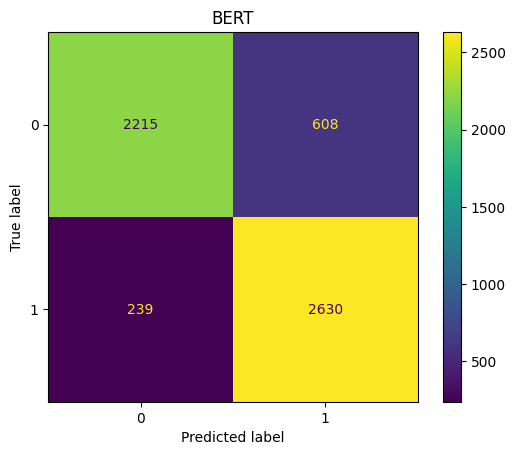

In [ ]:
y_pred = []
y_true = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks, batch_labels in data_loader(test_input_ids, test_attention_masks, test_labels, BATCH_SIZE):
        batch_input_ids = batch_input_ids.to(DEVICE)
        batch_attention_masks = batch_attention_masks.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        predictions = argmax(outputs.logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(batch_labels.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_display.plot()
plt.title("BERT")
plt.show()